In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import predictor_of_investment_helper_methods as hm 

In [143]:
def get_curts_FYMILP(case):
    df_curts_FYMILP = pd.read_csv(f"A.The_full_year_MILP/{case}/4.OutWoInv/oT_Result_RESCurtailment_{case}.csv")
    # Only considering existing lines:
    #df_utils_existing = df_utils_FYMILP[df_utils_FYMILP["Circuit"] == "eac1"]
    
    return df_curts_FYMILP

def get_curts_CM(case,cm,nbc): 
    ts_CM_All_lines = pd.read_csv(f"Y.FYTS_from_ByStages/{case}/{cm}/Curtailment_nc{nbc}_2.csv",header = [0],index_col=0)
    return ts_CM_All_lines

In [144]:
case = "IEEE118_mod1"

In [145]:
curts_FYMILP = get_curts_FYMILP(case).pivot(values = "MW",index = "LoadLevel",columns = "Unit").sum(axis = 1)
lu_FY = hm.get_utils_FYWOI(case).pivot(values = "GWh",index = "LoadLevel",columns = ["InitialNode","FinalNode"])


In [146]:
cm = "CHI"
nbc = 100
frame_MAES = pd.DataFrame(columns = ["cm","nbc","MAE_curt"])
for cm in ["R&D","OPC","OPT_LB","CHI","HI"]:  
    #Curtailment 
    curts_cm = get_curts_CM(case,cm,100).sum(axis = 1)
    MAE = curts_cm-curts_FYMILP
    this_frame = pd.DataFrame({"cm":[cm],"nbc":[nbc],"MAE_curt": [np.mean(np.abs(MAE))]})
    frame_MAES = pd.concat([frame_MAES,this_frame])
    

In [147]:
frame_MAES

,cm,nbc,MAE_curt
0,R&D,100,1884.864740
0,OPC,100,4509.822849
0,OPT_LB,100,4432.511336
0,CHI,100,3046.302436
0,HI,100,3005.848562


## Line utilization 

In [148]:
case = "RTS24_mod1"

In [149]:
lu_FY = hm.get_utils_FYWOI(case).pivot(values = "GWh",index = "LoadLevel",columns = ["InitialNode","FinalNode"])

In [150]:
lu_cm = hm.get_utils_cm("R&D",100,case)

In [151]:
np.mean(np.abs(lu_cm -lu_FY))

0.1176996713075296

In [152]:
arr_fy_all = np.zeros(lu_FY.shape[0]*lu_FY.shape[1])
arr_fy_cm = np.zeros(lu_FY.shape[0]*lu_FY.shape[1])

for i,col in enumerate(lu_FY.columns): 
    #print(col,lu_FY[col].to_numpy().shape,)
    arr_fy_all[i*8736:(i+1)*8736] = lu_FY[col].to_numpy()
    arr_fy_cm[i*8736:(i+1)*8736] = lu_cm[col].to_numpy()



In [153]:
filter_ = arr_fy_all>=0.80
np.mean(np.abs(arr_fy_all[filter_] -arr_fy_cm[filter_]))

0.1486627131942349

## Combined

In [88]:
case = "RTS24_mod1"

#curts_FYMILP = hm.get_curts_FYMILP(case).pivot(values = "MW",index = "LoadLevel",columns = "Unit").sum(axis = 1)
curts_FYMILP = hm.get_curts_FYWOI(case).pivot(values = "MW",index = "LoadLevel",columns = "Unit").sum(axis = 1)

lu_FY = hm.get_utils_FYWOI(case).pivot(values = "GWh",index = "LoadLevel",columns = ["InitialNode","FinalNode"])
net_dem_ph = hm.get_net_dem_FY(case)


In [89]:
cm = "CHI"
nbc = 100
frame_MAES = pd.DataFrame(columns = ["cm","nbc","MAE_curt","MAE_util"])

nbcs = [50,60,70,80,90,100,110,120,130,140,150]
nbcs = [50,60,70,80,90,100,150,200,250,300,400]
#nbcs = [40]
for nbc in nbcs:
    for cm in ["R&D","OPC","OPT_LB","CHI","HI"]:  

        #Curtailment 
        #curts_cm = get_curts_CM(case,cm,nbc).sum(axis = 1)
        curts_cm = hm.get_curts_cm(cm,nbc,case).sum(axis = 1)
        MAE_curt = curts_cm-curts_FYMILP
               


        #line_util
        lu_cm = hm.get_utils_cm(cm,nbc,case)
        arr_fy_all = np.zeros(lu_FY.shape[0]*lu_FY.shape[1])
        arr_fy_cm = np.zeros(lu_FY.shape[0]*lu_FY.shape[1])

        for i,col in enumerate(lu_FY.columns): 
            #print(col,lu_FY[col].to_numpy().shape,)
            arr_fy_all[i*8736:(i+1)*8736] = lu_FY[col].to_numpy()
            arr_fy_cm[i*8736:(i+1)*8736] = lu_cm[col].to_numpy()

        MAE_util = np.mean(np.abs(lu_cm -lu_FY))    
        
        filter_ = arr_fy_all>=0.85 
        MAE_util_filtered = np.mean(np.abs(arr_fy_all[filter_] -arr_fy_cm[filter_]))
        
        filter_2 = arr_fy_cm>=0.85 
        MAE_util_filtered_2 = np.mean(np.abs(arr_fy_all[filter_2] -arr_fy_cm[filter_2]))
        
        filter_3 = (arr_fy_cm>=0.85) |  (arr_fy_all>=0.85)
        MAE_util_filtered_3 = np.mean(np.abs(arr_fy_all[filter_3] -arr_fy_cm[filter_3]))
        
        #Net demand 
        df_net_dem = hm.get_net_dem_cm(cm, nbc, case)
        np_net_dem = df_net_dem["NetDemand"].to_numpy()
        MAE_nd = np.mean(np.abs(np_net_dem-net_dem_ph.to_numpy()))
        
        #MAE_nd = np.mean(np.abs(np.sort(np_net_dem)-np.sort(net_dem_ph.to_numpy())))

        
        this_frame = pd.DataFrame({"cm":[cm],"nbc":[nbc],
                                   "MAE_net_demand":MAE_nd,"MAE_curt": [np.mean(np.abs(MAE_curt))],
                                   "MAE_util":MAE_util,
                                   "MAE_util_filtered":[MAE_util_filtered],
                                   "MAE_util_filtered_2":[MAE_util_filtered_2],
                                   "MAE_util_filtered_3":[MAE_util_filtered_3],
                                  })
        frame_MAES = pd.concat([frame_MAES,this_frame])

<Axes: xlabel='nbc', ylabel='MAE_curt'>

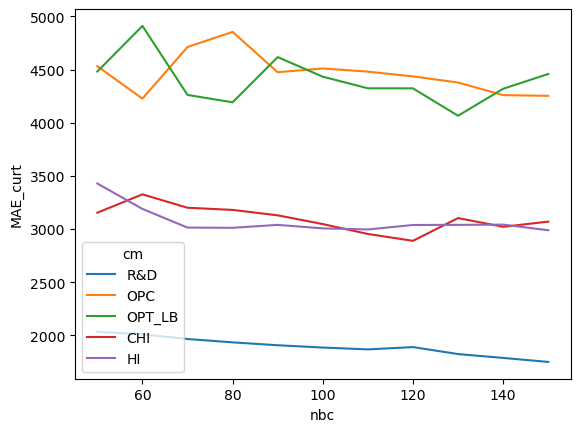

In [13]:
sns.lineplot(data= frame_MAES,x="nbc",y="MAE_curt",hue = "cm" )

In [90]:
frame_MAES.groupby("cm").mean()

,nbc,MAE_curt,MAE_util,MAE_net_demand,MAE_util_filtered,MAE_util_filtered_2,MAE_util_filtered_3
cm,,,,,,,
CHI,159.090909,498.577745,0.099757,1011.353149,0.083563,0.042439,0.101912
HI,159.090909,571.812091,0.105954,1093.115100,0.094146,0.053927,0.118015
OPC,159.090909,569.188674,0.100450,1168.515642,0.095978,0.061022,0.124035
OPT_LB,159.090909,682.431509,0.133496,1034.384694,0.238726,0.213631,0.322345
R&D,159.090909,567.849151,0.114467,752.230849,0.135050,0.166711,0.226937


In [ ]:
((frame_MAES.groupby("cm").max()/frame_MAES.groupby("cm").min())-1).drop(columns = "nbc")

# Combined and averaged

In [85]:
case = "9n_mod1"

#curts_FYMILP = hm.get_curts_FYMILP(case).pivot(values = "MW",index = "LoadLevel",columns = "Unit").sum(axis = 1)
curts_FYMILP = hm.get_curts_FYWOI(case).pivot(values = "MW",index = "LoadLevel",columns = "Unit").sum(axis = 1)

lu_FY = hm.get_utils_FYWOI(case).pivot(values = "GWh",index = "LoadLevel",columns = ["InitialNode","FinalNode"])
net_dem_ph = hm.get_net_dem_FY(case)
avg_curt_fy = curts_FYMILP.mean()

In [86]:
lu_FY.mean().mean()

0.3863886611721284

In [87]:
lu_FY.mean().mean()

0.3863886611721284

In [71]:
cm = "CHI"
nbc = 100
frame_MAES = pd.DataFrame(columns = ["cm","nbc","MAE_curt","MAE_util"])

#nbcs = [150]#,70,80,90,100,110,120,130,140,150]
nbcs = [50,60,70,80,90,100,150,200,250,300,400]
#nbcs = [40]
for nbc in nbcs:
    for cm in ["R&D","OPC","OPT_LB","CHI","HI"]:  

        #Curtailment 
        curts_cm = hm.get_curts_cm(cm,nbc,case).sum(axis = 1)
        MAE_curt = np.mean(np.abs(curts_cm-curts_FYMILP))/avg_curt_fy
               


        #line_util
        lu_cm = hm.get_utils_cm(cm,nbc,case)
        arr_fy_all = np.zeros(lu_FY.shape[0]*lu_FY.shape[1])
        arr_fy_cm = np.zeros(lu_FY.shape[0]*lu_FY.shape[1])

        for i,col in enumerate(lu_FY.columns): 
            #print(col,lu_FY[col].to_numpy().shape,)
            arr_fy_all[i*8736:(i+1)*8736] = lu_FY[col].to_numpy()
            arr_fy_cm[i*8736:(i+1)*8736] = lu_cm[col].to_numpy()

        MAE_util = np.mean(np.abs(lu_cm -lu_FY))/np.mean(arr_fy_all)
        print(np.mean(np.abs(lu_cm -lu_FY)))
        
        filter_ = arr_fy_all>=0.85 
        MAE_util_filtered = np.mean(np.abs(arr_fy_all[filter_] -arr_fy_cm[filter_]))/np.mean(arr_fy_all)
        
        filter_2 = arr_fy_cm>=0.85 
        MAE_util_filtered_2 = np.mean(np.abs(arr_fy_all[filter_2] -arr_fy_cm[filter_2]))/np.mean(arr_fy_all[filter_2])
        
        filter_3 = (arr_fy_cm>=0.85) |  (arr_fy_all>=0.85)
        MAE_util_filtered_3 = np.mean(np.abs(arr_fy_all[filter_3] -arr_fy_cm[filter_3]))/np.mean(arr_fy_all[filter_2])
        
        
        #Net demand 
        df_net_dem = hm.get_net_dem_cm(cm, nbc, case)
        np_net_dem = df_net_dem["NetDemand"].to_numpy()
        MAE_nd = np.mean(np.abs(np_net_dem-net_dem_ph.to_numpy()))/np.abs(net_dem_ph.mean())
        
        #MAE_nd = np.mean(np.abs(np.sort(np_net_dem)-np.sort(net_dem_ph.to_numpy())))

        
        this_frame = pd.DataFrame({"cm":[cm],"nbc":[nbc],
                                   "MAE_net_demand":MAE_nd,
                                   "MAE_curt": [MAE_curt],
                                   "MAE_util":MAE_util,
                                   "MAE_util_filtered":[MAE_util_filtered],
#                                    "MAE_util_filtered_2":[MAE_util_filtered_2],
#                                    "MAE_util_filtered_3":[MAE_util_filtered_3],
                                  })
        frame_MAES = pd.concat([frame_MAES,this_frame])

0.10010656743379012
0.126606267115746
0.12569691436465502
0.10131940089681533
0.10630904606413294
0.10024645983306524
0.12939947061414814
0.12490636718521834
0.09914502869575986
0.10452141788634499
0.09798256138395772
0.13082919555460537
0.11960607759294603
0.09559332882674704
0.10251367925997693
0.0986814311044505
0.1269996432549674
0.11804551376701164
0.09540226014824815
0.10046985904304404
0.09833709004596432
0.12487329201439624
0.11805393197526352
0.09458133200266543
0.1003996518107387
0.09597001058225982
0.12320195130889017
0.11411360866640625
0.09297386191926178
0.09913094152225169
0.09296433463499437
0.1174190689145381
0.11303190565132672
0.09175009351650226
0.0966388328878001


FileNotFoundError: [Errno 2] No such file or directory: 'Y.FYTS_from_ByStages/IEEE118_mod1/R&D/Curtailment_nc200_2.csv'

In [72]:
frame_MAES.groupby("cm").mean().drop(columns = "nbc")

,MAE_curt,MAE_util,MAE_net_demand,MAE_util_filtered
cm,,,,
CHI,0.400632,0.420415,2.442627,1.027507
HI,0.392867,0.444996,2.476065,1.086410
OPC,0.572057,0.551136,3.570275,1.565018
OPT_LB,0.568266,0.522383,3.590187,1.610873
R&D,0.244369,0.428891,1.083814,1.090354


In [73]:
((frame_MAES.groupby("cm").max()/frame_MAES.groupby("cm").min())-1).drop(columns = "nbc")

,MAE_curt,MAE_util,MAE_net_demand,MAE_util_filtered
cm,,,,
CHI,0.091736,0.104298,0.111815,0.234985
HI,0.147076,0.100066,0.094867,0.139022
OPC,0.148462,0.114207,0.205173,0.097695
OPT_LB,0.171353,0.112048,0.109546,0.235394
R&D,0.161552,0.078332,0.363580,0.164279


# Combined and sorted

In [65]:
case = "IEEE118_mod1"

curts_FYMILP = get_curts_FYMILP(case).pivot(values = "MW",index = "LoadLevel",columns = "Unit").sum(axis = 1)
lu_FY = hm.get_utils_FYWOI(case).pivot(values = "GWh",index = "LoadLevel",columns = ["InitialNode","FinalNode"])
net_dem_ph = hm.get_net_dem_FY(case)

In [66]:
#Same but everything sorted

frame_MAES = pd.DataFrame(columns = ["cm","nbc","MAE_curt","MAE_util"])

nbcs = [10,50,100,150]
nbcs = [10,20,30,40,50,60,70,80,90,100,150,200,250,300,400]
for nbc in nbcs:
    for cm in ["R&D","OPC","OPT_LB","CHI","HI"]:  

        #Curtailment 
        curts_cm = get_curts_CM(case,cm,nbc).sum(axis = 1)
        MAE_curt = np.sort(curts_cm)-np.sort(curts_FYMILP)


        #line_util
        lu_cm = hm.get_utils_cm(cm,nbc,case)
        arr_fy_all = np.zeros(lu_FY.shape[0]*lu_FY.shape[1])
        arr_fy_cm = np.zeros(lu_FY.shape[0]*lu_FY.shape[1])

        for i,col in enumerate(lu_FY.columns): 
            #print(col,lu_FY[col].to_numpy().shape,)
            arr_fy_all[i*8736:(i+1)*8736] = np.sort(lu_FY[col].to_numpy())
            arr_fy_cm[i*8736:(i+1)*8736] = np.sort(lu_cm[col].to_numpy())

        MAE_util = np.mean(np.abs(np.sort(lu_cm) -np.sort(lu_FY)))    
        filter_ = arr_fy_all>=0.80 
        MAE_util_filtered = np.mean(np.abs(arr_fy_all[filter_] -arr_fy_cm[filter_]))
        
        
        #Net demand 
        df_net_dem = hm.get_net_dem_cm(cm, nbc, case)
        np_net_dem = df_net_dem["NetDemand"].to_numpy()
        MAE_nd = np.mean(np.abs(np.sort(np_net_dem)-np.sort(net_dem_ph.to_numpy())))
        
        #MAE_nd = np.mean(np.abs(np.sort(np_net_dem)-np.sort(net_dem_ph.to_numpy())))

        
        this_frame = pd.DataFrame({"cm":[cm],"nbc":[nbc],"MAE_net_demand":MAE_nd,"MAE_curt": [np.mean(np.abs(MAE_curt))],"MAE_util":MAE_util,"MAE_util_filtered":[MAE_util_filtered]})
        frame_MAES = pd.concat([frame_MAES,this_frame])

FileNotFoundError: [Errno 2] No such file or directory: 'Y.FYTS_from_ByStages/IEEE118_mod1/R&D/Curtailment_nc200_2.csv'

In [ ]:
frame_MAES.groupby("cm").min()

In [ ]:
(frame_MAES.groupby("cm").max()/frame_MAES.groupby("cm").min())-1

# Combined no absolute

In [93]:
case = "IEEE118_mod1"

curts_FYMILP = hm.get_curts_FYWOI(case).pivot(values = "MW",index = "LoadLevel",columns = "Unit").sum(axis = 1)
lu_FY = hm.get_utils_FYWOI(case).pivot(values = "GWh",index = "LoadLevel",columns = ["InitialNode","FinalNode"])
net_dem_ph = hm.get_net_dem_FY(case)

In [94]:
#Same but no absolute errors

frame_MAES = pd.DataFrame(columns = ["cm","nbc","MAE_curt","MAE_util"])

nbcs = [10,50,100,150]
nbcs = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
nbcs = [150]
for nbc in nbcs:
    for cm in ["R&D","OPC","OPT_LB","CHI","HI"]:  

        #Curtailment 
        curts_cm = get_curts_CM(case,cm,nbc).sum(axis = 1)
        MAE_curt = (curts_cm)-(curts_FYMILP)


        #line_util
        lu_cm = hm.get_utils_cm(cm,nbc,case)
        arr_fy_all = np.zeros(lu_FY.shape[0]*lu_FY.shape[1])
        arr_fy_cm = np.zeros(lu_FY.shape[0]*lu_FY.shape[1])

        for i,col in enumerate(lu_FY.columns): 
            #print(col,lu_FY[col].to_numpy().shape,)
            arr_fy_all[i*8736:(i+1)*8736] = (lu_FY[col].to_numpy())
            arr_fy_cm[i*8736:(i+1)*8736] = (lu_cm[col].to_numpy())

        MAE_util = np.mean((lu_FY)-(lu_cm))  
        ME_util = arr_fy_cm[filter_]-arr_fy_all[filter_]
        filter_ = arr_fy_cm>=0.80 
        MAE_util_filtered = np.mean((arr_fy_cm[filter_]-arr_fy_all[filter_] ))
        
        
        #Net demand 
        df_net_dem = hm.get_net_dem_cm(cm, nbc, case)
        np_net_dem = df_net_dem["NetDemand"].to_numpy()
        MAE_nd = np.mean(((net_dem_ph.to_numpy()))-(np_net_dem))
        
        #MAE_nd = np.mean(np.abs(np.sort(np_net_dem)-np.sort(net_dem_ph.to_numpy())))

        
        this_frame = pd.DataFrame({"cm":[cm],"nbc":[nbc],"MAE_net_demand":MAE_nd,"MAE_curt": [np.mean((MAE_curt))],"MAE_util":MAE_util,"MAE_util_filtered":[MAE_util_filtered]})
        frame_MAES = pd.concat([frame_MAES,this_frame])

NameError: name 'get_curts_CM' is not defined

In [194]:
frame_MAES

,cm,nbc,MAE_curt,MAE_util,MAE_net_demand,MAE_util_filtered
0,R&D,150,-38.754850,0.000372,-62.037919,0.212485
0,OPC,150,-522.173786,0.008166,-401.915098,0.310681
0,OPT_LB,150,-494.864358,0.013738,-11.661157,0.261133
0,CHI,150,-548.760904,0.002772,-295.049258,0.197811
0,HI,150,-74.994903,0.007502,13.509289,0.203351


In [185]:
frame_MAES.groupby("cm").mean()

,nbc,MAE_curt,MAE_util,MAE_net_demand,MAE_util_filtered
cm,,,,,
CHI,40.0,112.692050,0.009637,864.191706,0.195787
HI,40.0,-664.030316,0.014523,-102.996603,0.230154
OPC,40.0,1115.892037,-0.012389,971.724373,0.382296
OPT_LB,40.0,225.535763,0.017161,155.766582,0.336469
R&D,40.0,-170.002487,-0.003586,-194.999274,0.224739
